In [1]:
import xarray as xr
import geopandas as gpd
import rioxarray  # For rasterizing with xarray
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import shape

In [2]:
burnscar = gpd.read_file("data\Burnt_LC0809_20240101_0531_Prv\Burnt_LC0809_20240101_0531_Prv.shp",crs=3857)
burnscar = burnscar.to_crs(4326)

hotspot = gpd.read_file("data\\DL_FIRE_SV-C2_571430\\fire_nrt_SV-C2_571430.shp",crs=4326)

sugarcanearea = gpd.read_file("data\\แผนที่สภาพการใช้ที่ดิน (แยกเอาเฉพาะที่เป็นอ้อย) -2022-2023\\พื้นที่ปลูกอ้อย.geojson")
sugarcanearea = sugarcanearea.to_crs(4326)

sugarplant = gpd.read_file("data\\ตำแหน่งโรงงานน้ำตาล\\โรงงานน้ำตาล.geojson")
sugarplant = sugarplant.to_crs(4326)

d:\workstation\ESDA_Sugarcan_vs_Hotspot\env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(
d:\workstation\ESDA_Sugarcan_vs_Hotspot\env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option CRS
  return ogr_read(


In [3]:
#### Create bounding box for Northeastern area ###
from shapely import geometry
p1 = geometry.Point(101,18.5)
p2 = geometry.Point(106,18.5)
p3 = geometry.Point(106,14)
p4 = geometry.Point(101,14)
pointList = [p1, p2, p3, p4,p1]
poly = geometry.Polygon([[p.x, p.y] for p in pointList])

#### Filter out only Northeastern ######
hotspot_ne = hotspot.loc[hotspot.geometry.within(poly)]
burnscar_ne = burnscar.loc[burnscar.geometry.within(poly)]
sugarcanearea_ne = sugarcanearea.loc[sugarcanearea.geometry.within(poly)]
sugarplant_ne = sugarplant.loc[sugarplant.geometry.within(poly)]
print(sugarplant_ne.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 23 entries, 8 to 54
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   objectid  23 non-null     int32   
 1   id        23 non-null     int32   
 2   name      23 non-null     object  
 3   province  23 non-null     object  
 4   x         23 non-null     float64 
 5   y         23 non-null     float64 
 6   geometry  23 non-null     geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 1.3+ KB
None


In [4]:
# 1. Create the Reference Grid (xarray DataArray):

### We r working with EPSG4326 ### 
#### Code is provided by Gemini and ChatGPT #### 

# Define the bounds and resolution of your grid
#### Here I focus on the Northeastern part of Thailand regarding the availability of our data #### 
minx, miny, maxx, maxy = 101, 14, 106, 18.5 

### with epsg4326 >>>> 1 degree of lat lon is roughly around 111,111 m
resolution = 0.0001 # 10  m

#### 1 ไร่ เท่ากับ 1600 ตรม ####
coarsen_scale = 400

# Create the x and y coordinates
x = np.arange(minx, maxx + resolution, resolution)
y = np.arange(miny, maxy + resolution, resolution)

# Create the DataArray (you can add a name and other dimensions later)
reference_grid = xr.DataArray(
    np.zeros((len(y), len(x))),  # Initialize with zeros
    coords={'y': y, 'x': x},
    dims=('y', 'x'),
    name="reference_grid"  # Give it a name
)
# Optional: Add a CRS (Coordinate Reference System)
reference_grid.rio.write_crs("EPSG:4326", inplace=True)

<xarray.DataArray 'reference_grid' (y: 45001, x: 50002)> Size: 18GB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(45001, 50002))
Coordinates:
  * y            (y) float64 360kB 14.0 14.0 14.0 14.0 ... 18.5 18.5 18.5 18.5
  * x            (x) float64 400kB 101.0 101.0 101.0 101.0 ... 106.0 106.0 106.0
    spatial_ref  int64 8B 0

In [5]:
# 2. Rasterize Polygons onto the Grid:

def to_rasterize(gdf,ref_grid):
    shapes = [(geom, 1) for i, geom in enumerate(gdf.geometry)]

    gdf_rasterized = rasterize(
        shapes,
        out_shape = ref_grid.shape,
        transform = ref_grid.rio.transform(),
        fill=0,
        all_touched=True,
        dtype=np.uint8
    )    
    gdf_rasterized_da = xr.DataArray(
    gdf_rasterized,
    coords={'y': y, 'x': x},
    dims=('y', 'x'),
    )   
    return gdf_rasterized_da

burnscar_ne_da = to_rasterize(burnscar_ne,reference_grid)
hotspot_ne_da = to_rasterize(hotspot_ne,reference_grid)
sugarcanearea_ne_da = to_rasterize(sugarcanearea_ne,reference_grid)
sugarplant_ne_da = to_rasterize(sugarplant_ne,reference_grid)

dataset = xr.Dataset({
    "burnscar_ne": burnscar_ne_da,
    "hotspot_ne": hotspot_ne_da,
    "sugarcanearea_ne": sugarcanearea_ne_da,
    "sugarplant_ne": sugarplant_ne_da
})

dataset.rio.write_crs("EPSG:4326", inplace=True)

<xarray.Dataset> Size: 9GB
Dimensions:           (y: 45001, x: 50002)
Coordinates:
  * y                 (y) float64 360kB 14.0 14.0 14.0 14.0 ... 18.5 18.5 18.5
  * x                 (x) float64 400kB 101.0 101.0 101.0 ... 106.0 106.0 106.0
    spatial_ref       int64 8B 0
Data variables:
    burnscar_ne       (y, x) uint8 2GB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    hotspot_ne        (y, x) uint8 2GB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    sugarcanearea_ne  (y, x) uint8 2GB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    sugarplant_ne     (y, x) uint8 2GB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [6]:
dataset
print(list(dataset.var()))

['burnscar_ne', 'hotspot_ne', 'sugarcanearea_ne', 'sugarplant_ne']


In [7]:
#### Coarsen to conduct feature engineering ####

xr_dataset = dataset.coarsen(y = coarsen_scale, x= coarsen_scale, boundary='trim').sum()

### Now we have percentage of pixel #####
xr_dataset['burnscar_ne'] = xr_dataset['burnscar_ne'] / (coarsen_scale**2)
xr_dataset['sugarcanearea_ne'] = xr_dataset['sugarcanearea_ne'] / (coarsen_scale**2)

### Normalize counting features #### 
max = xr_dataset['hotspot_ne'].max()
xr_dataset['hotspot_ne'] = xr_dataset['hotspot_ne'] / max

max = xr_dataset['sugarplant_ne'].max()
xr_dataset['sugarplant_ne'] = xr_dataset['sugarplant_ne'] / max

print(xr_dataset)

<xarray.Dataset> Size: 450kB
Dimensions:           (y: 112, x: 125)
Coordinates:
  * y                 (y) float64 896B 14.02 14.06 14.1 ... 18.38 18.42 18.46
  * x                 (x) float64 1kB 101.0 101.1 101.1 ... 105.9 105.9 106.0
    spatial_ref       int64 8B 0
Data variables:
    burnscar_ne       (y, x) float64 112kB 0.0 0.01359 0.01372 ... 0.0 0.0 0.0
    hotspot_ne        (y, x) float64 112kB 0.0 0.0 0.05556 0.0 ... 0.0 0.0 0.0
    sugarcanearea_ne  (y, x) float64 112kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sugarplant_ne     (y, x) float64 112kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0


In [8]:
df_dataset = xr_dataset.to_dataframe().reset_index()
gpd_dataset = gpd.GeoDataFrame(
    df_dataset, geometry=gpd.points_from_xy(df_dataset.x,df_dataset.y),crs = '4326')
gpd_dataset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   y                 14000 non-null  float64 
 1   x                 14000 non-null  float64 
 2   burnscar_ne       14000 non-null  float64 
 3   hotspot_ne        14000 non-null  float64 
 4   sugarcanearea_ne  14000 non-null  float64 
 5   sugarplant_ne     14000 non-null  float64 
 6   spatial_ref       14000 non-null  int64   
 7   geometry          14000 non-null  geometry
dtypes: float64(6), geometry(1), int64(1)
memory usage: 875.1 KB


In [9]:
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn
import pandas
import geopandas
import numpy
import matplotlib.pyplot as plt

cluster_variables = list(xr_dataset.var())

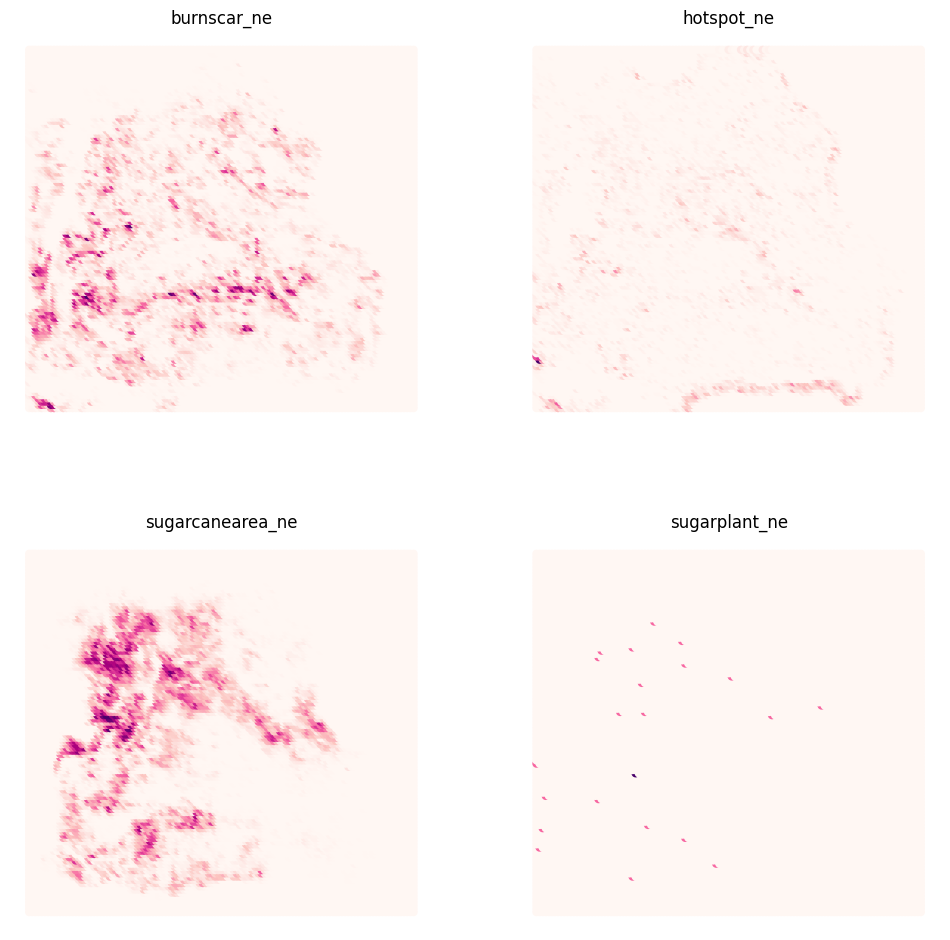

In [10]:
##### Choropleth plotting #####  


f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gpd_dataset.plot(
        column=col,
        ax=ax,
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [11]:
##### Calculate Spatial Autocorrelation of each features ####
### Small P value indicates that the feature is likely to be clustered ####

w = Queen.from_dataframe(gpd_dataset)
# Set seed for reproducibility
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(gpd_dataset[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pandas.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

C:\Users\595078\AppData\Local\Temp\ipykernel_7032\3645486939.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gpd_dataset)


,Moran's I,P-value
Variable,,
burnscar_ne,0.597767,0.001
hotspot_ne,0.415084,0.001
sugarcanearea_ne,0.809355,0.001
sugarplant_ne,-0.001514,0.334


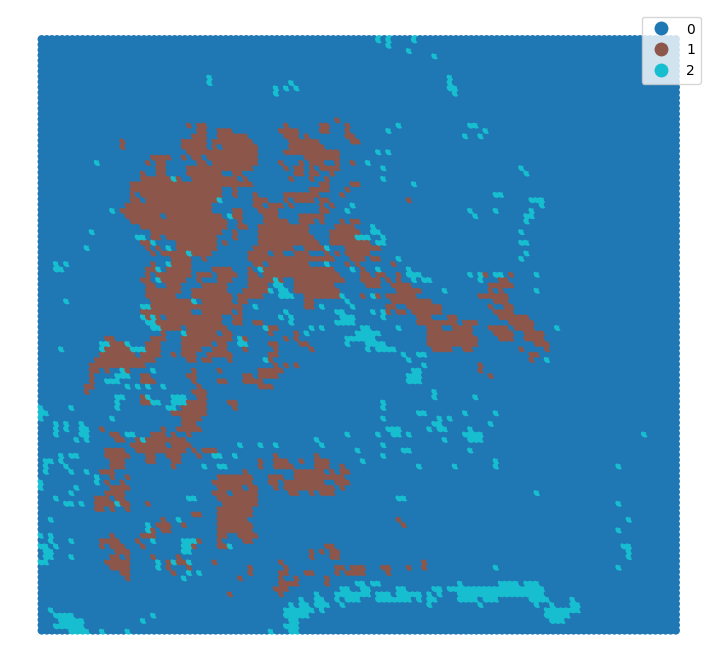

In [12]:
# Initialize KMeans instance
from sklearn.cluster import KMeans
from sklearn.preprocessing import robust_scale

db_scaled = robust_scale(gpd_dataset[cluster_variables])
# Initialize KMeans instance
n_clusters=3
kmeans = KMeans(n_clusters)

# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
cls = kmeans.fit(db_scaled)

# Print first five labels
cls.labels_[:n_clusters]

# Assign labels into a column
gpd_dataset["cls"] = cls.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
gpd_dataset.plot(
    column="cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [13]:
# Group data table by cluster label and count observations
ksizes = gpd_dataset.groupby("cls").size()
ksizes

cls
0    11785
1     1664
2      551
dtype: int64

In [14]:
# Index db on cluster ID
tidy_db = gpd_dataset.set_index("cls")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,cls,Attribute,Values
0,0,burnscar_ne,0.000000
1,0,hotspot_ne,0.000000
2,0,sugarcanearea_ne,0.000000
3,0,sugarplant_ne,0.000000
4,0,burnscar_ne,0.013588


d:\workstation\ESDA_Sugarcan_vs_Hotspot\env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
d:\workstation\ESDA_Sugarcan_vs_Hotspot\env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
d:\workstation\ESDA_Sugarcan_vs_Hotspot\env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
d:\workstation\ESDA_Sugarcan_vs_Hotspot\env\Lib\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`

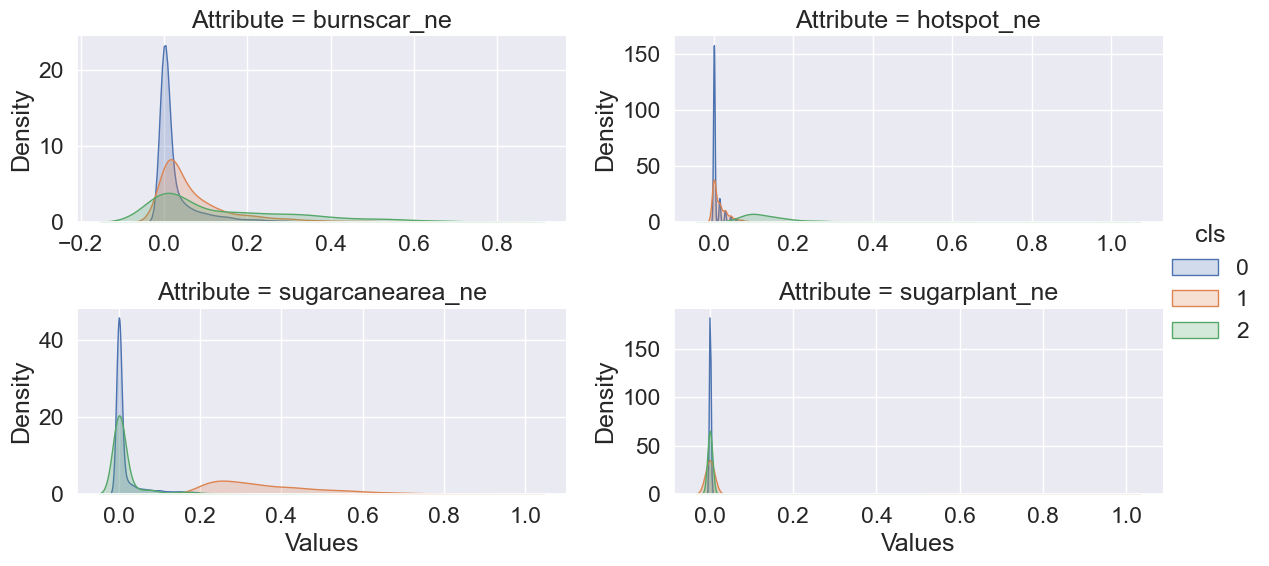

In [15]:
# Scale fonts to make them more readable
seaborn.set(font_scale=1.5)
# Setup the facets
facets = seaborn.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="cls",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=2,
)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, "Values", shade=True).add_legend()